In [1]:
import numpy as np
from scipy.stats import rankdata  # Make sure this is included!
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime as dt


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
stock_data = pd.read_pickle("./usa_131_per_size_ranks_False.pkl")
stock_data

,id,date,size_grp,cowc_gr1a,oaccruals_at,oaccruals_ni,taccruals_at,taccruals_ni,debt_gr3,fnl_gr1a,...,div12m_me,ebitda_mev,eq_dur,eqnpo_12m,eqnpo_me,eqpo_me,ni_me,ocf_me,sale_me,r_1
0,10006,1963-01-31,large,0.070236,0.420000,0.478462,-0.392308,-0.430769,0.452528,0.479282,...,-0.122528,0.095568,-0.256881,-0.162338,0.000000,0.000000,-0.147790,-0.465470,0.103591,0.036440
1,10014,1963-01-31,micro,0.488873,0.444615,0.446154,0.423077,0.438462,0.000000,0.411602,...,-0.500000,-0.127424,-0.143731,-0.409091,0.000000,0.000000,0.064917,-0.469613,0.232044,-0.035593
2,10102,1963-01-31,large,0.128651,0.349231,0.350769,0.226154,0.309231,0.163571,0.313536,...,0.138865,-0.159280,0.168196,-0.461039,0.000000,0.000000,-0.220994,-0.325967,-0.222376,-0.006685
3,10145,1963-01-31,mega,-0.168985,0.238462,0.226154,0.349231,0.344615,-0.207946,-0.207182,...,-0.009028,-0.220222,0.279817,-0.478896,0.000000,0.000000,-0.299724,-0.218232,-0.317680,-0.036420
4,10153,1963-01-31,large,-0.376217,-0.256923,-0.210769,-0.260000,-0.172308,-0.096491,-0.070442,...,0.221410,-0.336565,-0.481651,0.405844,0.000000,0.000000,-0.277624,0.088398,0.338398,-0.024319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487003,93426,2022-11-30,small,0.000435,0.185551,0.202183,0.139719,0.141966,0.318271,-0.105762,...,-0.500000,0.198782,-0.103350,0.041766,-0.093366,-0.227869,0.153088,0.079917,0.120158,-0.050705
2487004,93427,2022-11-30,large,0.375254,0.370062,0.345114,0.340135,0.300832,-0.398225,-0.200753,...,-0.500000,-0.053451,0.083755,0.081543,0.056281,-0.013115,0.069279,-0.075246,0.012934,-0.042282
2487005,93434,2022-11-30,micro,-0.448941,-0.377339,-0.098233,-0.340915,-0.063703,0.274955,0.195302,...,-0.500000,-0.405277,0.441530,-0.372713,-0.437582,-0.096995,-0.456668,-0.426310,0.310213,0.338963
2487006,93436,2022-11-30,mega,-0.318103,-0.224532,-0.091476,0.188329,0.169527,-0.409950,-0.399040,...,-0.500000,-0.179026,0.252528,-0.310925,-0.186602,-0.381967,-0.070835,-0.085106,-0.353505,-0.370713


## defining transformer structure 


In [16]:


class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super().__init__()
        self.H = H
        self.W = nn.ParameterList([nn.Parameter(torch.randn(D, D)/100) for _ in range(H)])
        self.V = nn.ParameterList([nn.Parameter(torch.randn(D, D)/100) for _ in range(H)])

    def forward(self, X):  # X: [N_t, D]
        heads = []
        for h in range(self.H):
            
            scores = X @ self.W[h] @ X.T/(X.shape[1] ** 0.5)          # [N_t, N_t]
            weights = F.softmax(scores, dim=1) + 1e-8      # softmax row-wise
            A_h = weights @ X @ self.V[h]           # [N_t, D]
            heads.append(A_h)
        return sum(heads)                           # [N_t, D]

class FeedForward(nn.Module):
    def __init__(self, D, dF):
        super().__init__()
        self.fc1 = nn.Linear(D, dF)
        self.fc2 = nn.Linear(dF, D)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, X):  # X: [N_t, D]

        return self.dropout(self.fc2(F.relu(self.fc1(X))))  # [N_t, D]

# class MultiHeadAttention(nn.Module):
#     def __init__(self, D, H):
#         super().__init__()
#         self.D = D
#         self.H = H
#         self.d_proj = D * H

#         # Q, K, V linear projections (shared dimensions)
#         self.W_q = nn.Linear(D, self.d_proj)
#         self.W_k = nn.Linear(D, self.d_proj)
#         self.W_v = nn.Linear(D, self.d_proj)

#         # optional final projection (can keep or skip)
#         self.out_proj = nn.Linear(self.d_proj, D)

#     def forward(self, X):  # X: [N_t, D]
#         N = X.size(0)

#         Q = self.W_q(X).view(N, self.H, self.D)  # [N, H, D]
#         K = self.W_k(X).view(N, self.H, self.D)
#         V = self.W_v(X).view(N, self.H, self.D)

#         attn_scores = torch.einsum('nhd,mhd->nhm', Q, K) / (self.D ** 0.5)  # [N, H, N]
#         attn_weights = torch.softmax(attn_scores, dim=-1)  # attention across assets

#         context = torch.einsum('nhm,mhd->nhd', attn_weights, V)  # [N, H, D]
#         context = context.reshape(N, -1)  # [N, H*D]

#         return self.out_proj(context)  # [N, D]

    

    
class TransformerBlock(nn.Module):
    def __init__(self, D, H, dF):
        super().__init__()
        self.attn = MultiHeadAttention(D, H)
        self.ffn = FeedForward(D, dF)
        self.norm1 = nn.LayerNorm(D)
        self.norm2 = nn.LayerNorm(D)

    def forward(self, X):  # X: [N_t, D]
        X = self.norm1(X + self.attn(X))  # normalize after attention residual
        X = self.norm2(X + self.ffn(X))   # normalize after FFN residual
        return X

    
class NonlinearPortfolioForward(nn.Module):
    def __init__(self, D, K, H=1, dF=256):
        super().__init__()
        self.blocks = nn.ModuleList([TransformerBlock(D, H, dF) for _ in range(K)])
        self.lambda_out = nn.Parameter(torch.randn(D, 1)/1000)  # final projection

    def forward(self, X):  # X: [N_t, D]
        for block in self.blocks:
            X = block(X)  # propagate through K blocks
        w_t = X @ self.lambda_out# [N_t, 1]

        return w_t.squeeze()/w_t.sum()       # [N_t]


## fitting one datapoint


In [4]:
X_t = stock_data[stock_data["date"] == pd.Timestamp("2020-12-31")].drop(columns = ["r_1", "id", "date", "size_grp"])
R_t_plus_one = stock_data[stock_data["date"] == pd.Timestamp("2020-12-31")][["r_1"]]
print("X_t:\n")
print(X_t)
print("R_t+1")
print(R_t_plus_one)

X_t:

         cowc_gr1a  oaccruals_at  oaccruals_ni  taccruals_at  taccruals_ni  \
2398352   0.053532     -0.074965     -0.232962     -0.123539     -0.252922   
2398353   0.428728      0.345619      0.366759      0.255704      0.284919   
2398354   0.020879      0.140612      0.041029      0.066778     -0.004452   
2398355  -0.369388     -0.247149     -0.290264     -0.257095     -0.299666   
2398356   0.062637      0.210709      0.233241      0.079577      0.136338   
...            ...           ...           ...           ...           ...   
2401944   0.000000      0.383171      0.447983      0.444352      0.496105   
2401945  -0.494035     -0.456885     -0.212378     -0.386199     -0.107123   
2401946  -0.083046      0.331433      0.123366     -0.460490     -0.485810   
2401947  -0.050706      0.253547      0.217107      0.235949      0.226767   
2401948   0.000000      0.359249      0.296106      0.351141      0.415971   

         debt_gr3  fnl_gr1a  ncol_gr1a  nfna_gr1a    noa_

## Training loop -------

In [7]:
months_list = stock_data["date"].unique()
columns_to_drop_in_x = ["size_grp", "date", "r_1", "id"]
window = 60
epoch = 1
K = 2
D = stock_data.shape[1] - len(columns_to_drop_in_x)
H = 2
dF = 64
t = 150  # --> 61st month in the months_list

lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

model = NonlinearPortfolioForward(D=D, K=K, H=H, dF=dF).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

losses = []
returns = []

for month in months_list[t - window:t]:  # this loop iterates until t-1
    month_data = stock_data[stock_data["date"] == month]

    X_t = month_data.drop(columns=columns_to_drop_in_x)

    R_t_plus_one = torch.tensor(
        month_data["r_1"].values,
        dtype=torch.float32,
        device=device
    )
    
    X_t_tensor = torch.tensor(X_t.values, dtype=torch.float32, device=device)  # Shape: [N_t, D]
    w_t = model(X_t_tensor)  # Shape: [N_t]

    loss = (1 - torch.dot(w_t, R_t_plus_one)).pow(2)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    for name, param in model.named_parameters():
        if torch.isnan(param.grad).any():
            print(f"NaN detected in gradient of {name}")
            break

    portfolio_return = torch.dot(w_t, R_t_plus_one).item()
    losses.append(loss.item())
    returns.append(portfolio_return)

    optimizer.step()

    print(f"  month {month}  loss={loss.item():.6f} return={w_t @ R_t_plus_one}")


  month 1970-07-31 00:00:00  loss=0.961597 return=0.019389683380723
  month 1970-08-31 00:00:00  loss=0.820427 return=0.09422603249549866
  month 1970-09-30 00:00:00  loss=1.120282 return=-0.058433741331100464
  month 1970-10-31 00:00:00  loss=0.962096 return=0.019134849309921265
  month 1970-11-30 00:00:00  loss=0.814618 return=0.0974380299448967
  month 1970-12-31 00:00:00  loss=0.799706 return=0.10573747754096985
  month 1971-01-31 00:00:00  loss=0.932178 return=0.034506458789110184
  month 1971-02-28 00:00:00  loss=0.898970 return=0.05185979604721069
  month 1971-03-31 00:00:00  loss=0.940036 return=0.03044569306075573
  month 1971-04-30 00:00:00  loss=1.102336 return=-0.04992186278104782
  month 1971-05-31 00:00:00  loss=1.034944 return=-0.017321985214948654
  month 1971-06-30 00:00:00  loss=1.107538 return=-0.05239606648683548
  month 1971-07-31 00:00:00  loss=0.907591 return=0.04732440784573555
  month 1971-08-31 00:00:00  loss=0.991711 return=0.004153154324740171
  month 1971-0

### now it has been trained from t-60 to t-1, time to give him informations at t and get the weights w_t.
To see if it fucking worked than do w_t @ R_t_plus_1

In [12]:
month_data = stock_data[stock_data["date"] == months_list[t]]

X_t = month_data.drop(columns=columns_to_drop_in_x)

R_t_plus_one = torch.tensor(
    month_data["r_1"].values,
    dtype=torch.float32,
    device=device
)

X_t_tensor = torch.tensor(X_t.values, dtype=torch.float32, device=device)  # Shape: [N_t, D]
w_t = model(X_t_tensor)  # Shape: [N_t]
w_t@R_t_plus_one

tensor(-0.0989, grad_fn=<DotBackward0>)

# NOW LET'S DO THIS FOR BUNCH OF t 

In [23]:

portfolio_ret = []
for t in range(200, len(months_list)):
    model = NonlinearPortfolioForward(D=D, K=K, H=H, dF=dF).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    losses = []
    returns = []
    print(months_list[t])

    for month in months_list[t - window:t]:  # this loop iterates until t-1
        month_data = stock_data[stock_data["date"] == month]

        X_t = month_data.drop(columns=columns_to_drop_in_x)

        R_t_plus_one = torch.tensor(
            month_data["r_1"].values,
            dtype=torch.float32,
            device=device
        )

        X_t_tensor = torch.tensor(X_t.values, dtype=torch.float32, device=device)  # Shape: [N_t, D]
        w_t = model(X_t_tensor)  # Shape: [N_t]

        loss = (1 - torch.dot(w_t, R_t_plus_one)).pow(2)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        portfolio_return = torch.dot(w_t, R_t_plus_one).item()
        losses.append(loss.item())
        returns.append(portfolio_return)

        optimizer.step()

        #print(f"  month {month}  loss={loss.item():.6f} return={w_t @ R_t_plus_one}")
    month_data = stock_data[stock_data["date"] == months_list[t]]

    X_t = month_data.drop(columns=columns_to_drop_in_x)

    R_t_plus_one = torch.tensor(
        month_data["r_1"].values,
        dtype=torch.float32,
        device=device
    )

    X_t_tensor = torch.tensor(X_t.values, dtype=torch.float32, device=device)  # Shape: [N_t, D]
    w_t = model(X_t_tensor)  # Shape: [N_t]

    predicted = (w_t @ R_t_plus_one).item()
    portfolio_ret.append(predicted)
    print(predicted)



1979-09-30 00:00:00
-0.08768456429243088
1979-10-31 00:00:00
0.6532599329948425
1979-11-30 00:00:00
0.12158513069152832
1979-12-31 00:00:00
0.07817015796899796
1980-01-31 00:00:00


KeyboardInterrupt: 

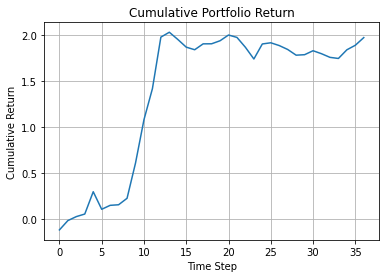

In [22]:
import matplotlib.pyplot as plt

cumulative_return = np.cumsum(np.asarray(portfolio_ret))

plt.plot(cumulative_return)
plt.title("Cumulative Portfolio Return")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()